**NEXT STEPS**
* Reprendre le code du SIFT avec le TP vision dans le sandbox
* Intégrer l'étape de PCA + TSNE avant de calculer l'ARI sur les modèles CNN en transfer learning
* Score à atteindre : environ 0.70

In [24]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '10'  # Définir à 10 cœurs

In [2]:
# Importe EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize

from multiprocessing import Pool

In [3]:
%%capture
%run preprocessing.ipynb

# IMAGES

**RECUPERATION DES IMAGES DANS LE REPERTOIRE**

In [4]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

# Création de la liste contenant les chemins d'accès ordonnées
image_paths = [path + image for image in flipkart_filtered["image"]]

In [5]:
# Création d'un dataframe avec les dimensions de chaque image
res_frame = pd.DataFrame([cv2.imread(image_path).shape for image_path in image_paths])
res_frame.rename(columns={0: "height", 1: "width", 2: "channels"}, inplace=True)

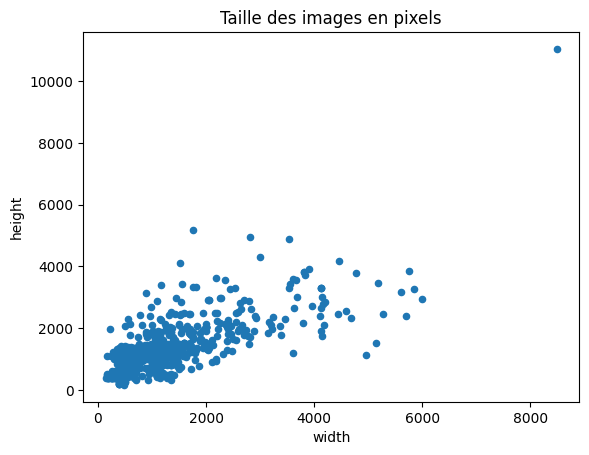

In [6]:
# Scatter plot de la taille des images
res_frame.filter(["height", "width"]).plot(kind='scatter', x='width', y='height')
plt.title("Taille des images en pixels")
plt.show()

**RESIZE DES IMAGES AVEC UNE FONCTION CUSTOM DE REDIMENSIONNEMENT**

In [6]:
def resizeAndPad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA

    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = float(w)/h 
    saspect = float(sw)/sh

    if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0

    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape)==3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

**RESIZE DES IMAGES AVEC LA FONCTION RESIZE OPEN CV / TENSORFLOW / CUSTOM**

In [13]:
# Définition de la size pour le redimensionnement
size = (224, 224)

# Redimensionnement des images en 224x224 pixels en gardant l'aspect ratio
custom_224= np.array([resizeAndPad(cv2.imread(image_path), size, padColor=255) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 224x224 pixels en gardant l'aspect ratio de tensorflow
opencv_224 = np.array([cv2.resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 224x224 pixels en gardant l'aspect ratio de tensorflow
tf_224 = np.array([resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])

In [15]:
# Définition de la size pour le redimensionnement
size = (336, 336)

# Redimensionnement des images en 336, 336 pixels en gardant l'aspect ratio
custom_336= np.array([resizeAndPad(cv2.imread(image_path), size, padColor=255) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 336, 336 pixels en gardant l'aspect ratio de tensorflow
opencv_336 = np.array([cv2.resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 336, 336 pixels en gardant l'aspect ratio de tensorflow
tf_336 = np.array([resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])

100%|██████████| 1050/1050 [00:22<00:00, 47.67it/s]


## CNN

In [82]:
def ARI_cnn(images, n_clusters=7, preprocessing=True):
    # Crée un data generator pour les images
    if preprocessing:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    else:
        datagen=ImageDataGenerator()

    # Crée le data generator
    datagenerator = datagen.flow(
        images,
        batch_size=32,
        shuffle=False  # Ne pas mélanger les images pour pouvoir les retrouver plus tard lors du calcul de l'adjusted rand score
    )
    # Crée les embeddings
    embeddings = embedding_model.predict(datagenerator)
    # Affiche la taile des embeddings
    print('Raw shape: ', embeddings.shape)
    embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
    print('Flat shape: ', embeddings_flat.shape)

    # Réduction de la dimensionnalité des embeddings
    pca = PCA(n_components=0.95)

    # Fit et transforme les embeddings
    embeddings_pca = pca.fit_transform(embeddings_flat)
    # Affiche la taille des embeddings après PCA
    print('PCA shape: ', embeddings_pca.shape)

    # Crée le modèle KMeans
    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings_pca)

    ari = adjusted_rand_score(flipkart_filtered['category_0'], clusters)
    print(f"Adjusted Rand Index: {ari}")
    return ari

In [37]:
ari_scores = []

### EFFICIENT NET CLASSIFICATION

Le modèle EfficientNetB0 est un modèle de convolution pré-entraîné sur ImageNet qui est capable de classifier des images en 1000 catégories.<br>
Nous allons retirer la dernière couche du modèle et recréer une nouvelle couche de classification avec 7 classes qui correspondent aux catégories de produits.<br>


Commençons par charger le modèle EfficientNetB0 pré-entraîné sur ImageNet et retirer la dernière couche de classification:

In [9]:
# Charge le modèle sous la variable efficient_model
efficient_model = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
    )

In [11]:
%%capture
# Affiche l'architecture du modèle
efficient_model.summary()

Le modèle est composé d'un grand nombre de couche de convolution et de normalisation qui permettent d'extraire des features de plus en plus abstraites des images.<br>
Nous allons ajouter une couche de classification avec 7 neurones qui correspondent aux catégories de produits.

In [9]:
# On récupère l'output du modèle
x = efficient_model.output

In [10]:
# Ajout d'une couche de pooling suivant d'une couche FC puis d'une couche de classification à 7 classes
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)

In [11]:
# Création du modèle à jour avec les couches d'entrée d'efficient et les couches de sortie ajoutées
updated_model = Model(inputs=efficient_model.input, outputs=x)

In [12]:
# Paramètre les couches de l'input à trainable=False
for layer in efficient_model.layers:
    layer.trainable = False

In [13]:
# Compile le modèle
updated_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

A présent, pour entraîner notre modèle, nous allons devoir préparer nos données d'image pour les envoyer dans le modèle.<br>

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
train_datagen_wh = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    flipkart_filtered,
    directory=path,
    x_col='image',
    y_col='category_0',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 1050 validated image filenames belonging to 7 classes.


In [16]:
updated_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10
)

Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.1555 - loss: 1.9865

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 22/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.1515 - loss: 1.9810

KeyboardInterrupt: 

Les dimensions HxLxC du tenseur d'entrée sont 224x224x3.<br>
Je dois adapter toutes les images à ces dimensions pour pouvoir les envoyer dans le modèle CNN:

In [ ]:
# Création d'une liste qui contient toutes les images redimensionnées sous forme de batch



### EFFICIENT NET EMBEDDINGS

In [43]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [44]:
# Définition de la taille des images
size = (224, 224)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 7, 7, 1280)

In [45]:
%%capture
eff_model.summary()

In [46]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [47]:
for image in tqdm([opencv_224, tf_224, custom_224]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step 
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 33%|███▎      | 1/3 [01:16<02:32, 76.11s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.32339832231164917


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 67%|██████▋   | 2/3 [02:05<01:00, 60.46s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.3244894274108034


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


100%|██████████| 3/3 [03:00<00:00, 60.28s/it]

PCA shape:  (1050, 623)
Adjusted Rand Index: 0.17948141823801084


In [48]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084]


In [77]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 11, 11, 1280)

In [78]:
%%capture
eff_model.summary()

In [79]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [83]:
ARI_cnn(opencv_336, preprocessing=False)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)
PCA shape:  (1050, 743)
Adjusted Rand Index: 0.3556772032685982


0.3556772032685982

In [53]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084, 0.3556772032685982, 0.3556772032685982, 0.15248888772357608]


In [ ]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 11, 11, 1280)

In [ ]:
%%capture
eff_model.summary()

In [ ]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [ ]:
for image in tqdm([opencv_336, tf_336, custom_336]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)
PCA shape:  (1050, 743)


 33%|███▎      | 1/3 [02:18<04:36, 138.43s/it]

Adjusted Rand Index: 0.3556772032685982


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)


 67%|██████▋   | 2/3 [04:20<02:08, 128.72s/it]

PCA shape:  (1050, 743)
Adjusted Rand Index: 0.3556772032685982


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)


100%|██████████| 3/3 [06:15<00:00, 125.20s/it]

PCA shape:  (1050, 704)
Adjusted Rand Index: 0.15248888772357608


In [ ]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084, 0.3556772032685982, 0.3556772032685982, 0.15248888772357608]


### VGG16 EMBEDDINGS

In [96]:
ari_scores = []

In [97]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [98]:
# Définition de la taille des images
size = (224, 224)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle vgg16
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
vgg16_model.output.shape

(None, 7, 7, 512)

In [99]:
%%capture
vgg16_model.summary()

In [100]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(vgg16_model.input, last_conv_layer.output)

In [102]:
ARI_cnn(opencv_224, preprocessing=False)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step
Raw shape:  (1050, 14, 14, 512)
Flat shape:  (1050, 100352)
PCA shape:  (1050, 777)
Adjusted Rand Index: 0.12095135314160917


0.12095135314160917

In [95]:
for image in tqdm([opencv_224, tf_224, custom_224]):
    ari_scores.append(ARI_cnn(image, preprocessing=False))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4:02 8s/step

  0%|          | 0/3 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(ari_scores)

In [ ]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
# Création du modèle vgg16
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
vgg16_model.output.shape

(None, 11, 11, 1280)

In [ ]:
%%capture
vgg16_model.summary()

In [ ]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(vgg16_model.input, last_conv_layer.output)

In [ ]:
for image in tqdm([opencv_336, tf_336, custom_336]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step 
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)
PCA shape:  (1050, 666)


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
 33%|███▎      | 1/3 [01:13<02:27, 73.52s/it]

Adjusted Rand Index: 0.32339832231164917


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 893ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 67%|██████▋   | 2/3 [02:24<01:11, 71.75s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.3244894274108034


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 719ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


100%|██████████| 3/3 [03:10<00:00, 63.63s/it]

PCA shape:  (1050, 623)
Adjusted Rand Index: 0.17948141823801084


In [ ]:
print(ari_scores)

### VGG16 CLASSIFICATION

In [8]:
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [9]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_classes = flipkart_filtered['category_0'].nunique()

In [ ]:
x = vgg16_model.output

# Ajoute une couche de classification à 7 classes
x = Dense(n_classes, activation='softmax')(x)

In [ ]:
# Crée le modèle
vgg16 = Model(inputs=vgg16_model.input, outputs=x)

# Paramètre les couches de l'input à trainable=False pour ne pas réentraîner les poids et faire de l'extraction features
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
# Compile le modèle
vgg16.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## VISUAL BAG OF WORDS

In [7]:
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator

La colonne `image`dans le dataframe `flipkart_filtered`contient l'ordre d'apparition des images.<br>
Nous allons spécifiquement recréer la liste des chemins de fichier en utilisant cet ordre :

In [8]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

# Création de la liste contenant les chemins d'accès ordonnées
image_paths = [path + image for image in flipkart_filtered["image"]]

**PRETRAITEMENT DES IMAGES (NIVEAUX DE GRIS ET EGALISATION DE L'HISTOGRAMME) et EXTRACTION DES DESCRIPTEURS SIFT**

Nous pouvons maintenant passer à l'étape d'extraction des features SIFT pour chaque image.<br>
Nous allons créer une liste contenant tous les descripteurs SIFT pour chaque image que nous pourrons réutiliser par la suite :

In [9]:
# identification of key points and associated descriptors
sift_descriptors = []
image_list = []

# Instancie un objet SIFT
sift = cv2.SIFT_create()

# Phase de prétraitement des images et extraction des descripteurs SIFT
for img_path in tqdm(image_paths):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Lit l'image en niveaux de gris
    image = cv2.equalizeHist(image)   # Egalise l'image pour améliorer le contraste
    image_list.append(image)
    _, descriptor = sift.detectAndCompute(image, None)
    sift_descriptors.append(descriptor)

100%|██████████| 1050/1050 [09:22<00:00,  1.87it/s] 


In [10]:
# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors, axis=0)
print("Points d'intérêts / descripteurs image non égalisée : ", X.shape)

Points d'intérêts / descripteurs image non égalisée :  (9051350, 128)


**SEGMENTATION DES DESCRIPTEURS / RECHERCHE DU NOMBRE OPTIMAL DE CLUSTERS / VISUAL WORDS**

In [11]:
# Récupère les labels uniques dans une liste
list_labels = list(flipkart_filtered['category_0'].unique())
print(list_labels)

['Home Furnishing ', 'Baby Care ', 'Watches ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ', 'Beauty and Personal Care ', 'Computers ']


In [12]:
# Fonction pour déterminer un range de cluster à tester pour déterminer le nombre optimal de Visual Words
def cluster_range(X, n=10):    
    # Détermination du nombre de clusters avec la racine carrée du nombre de descriptors
    n_clusters_sqrt = int(np.sqrt(len(X)))
    print("Nombre de clusters - méthode racine carrée : ", n_clusters_sqrt)

    # Détermination du nombre de clusters par multiplier par 10 le nombre de labels existants
    n_clusters_ten = len(list_labels) * 10
    print("Nombre de clusters - méthode nbre_labels * 10 : ", n_clusters_ten)

    # Créatio d'une liste de n clusters à tester
    rng_clusters = np.linspace(n_clusters_ten, n_clusters_sqrt, n).astype(int)
    print("Longueur de la liste de clusters à tester: ", len(rng_clusters))

    return rng_clusters

In [13]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def return_inertia_labels(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    return inertia, labels

In [14]:
def plot_optimalk(X, rng_clusters):    
    # Tester plusieurs valeurs de clusters pour trouver le meilleur
    inertia_list = []
    labels_list = []
    for n_clusters in tqdm(rng_clusters):
        inertia, labels = return_inertia_labels(X, n_clusters)
        inertia_list.append(inertia)
        labels_list.append(labels)
    
    # Détermine le optimal-K avec la méthode du coude
    optimal_k = KneeLocator(rng_clusters, inertia_list, curve='convex', direction='decreasing').elbow

    # Affiche la courbe d'inertie en fonction du nombre de clusters
    plt.figure(figsize=(12, 6))
    plt.plot(rng_clusters, inertia_list, marker='o')
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title('Inertie en fonction du nombre de clusters')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
# Détermine le nombre de cluster à garder en fonction de l'inertie
rng_clusters = cluster_range(X)

Nombre de clusters - méthode racine carrée :  3008
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  10


100%|██████████| 10/10 [46:45<00:00, 280.51s/it]


NameError: name 'KneeLocator' is not defined

100%|██████████| 10/10 [44:05<00:00, 264.55s/it]


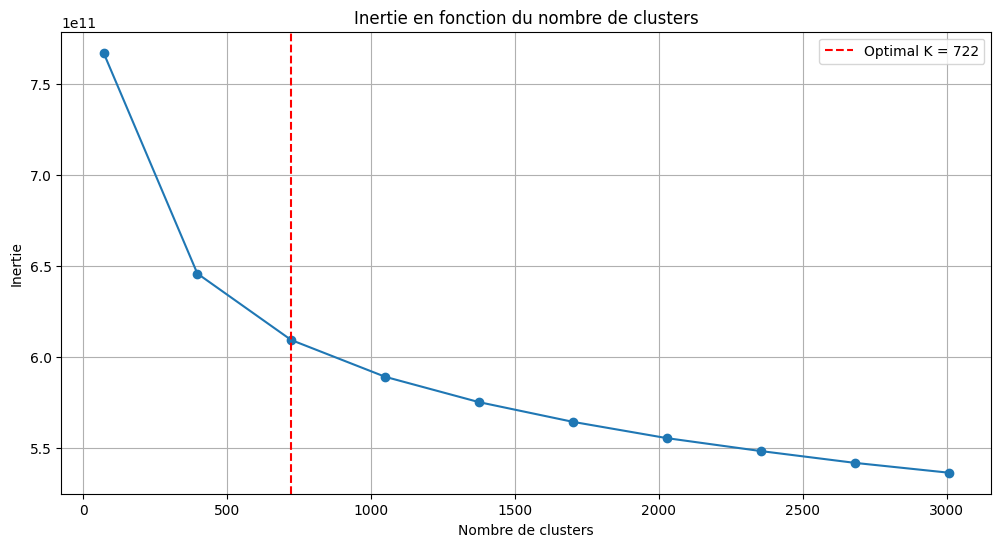

In [26]:
plot_optimalk(X, rng_clusters)

Optimal K : 722

**CREATION DES VECTEURS A PARTIR DES HISTOGRAMMES DE VISUAL WORDS POUR TOUTES LES IMAGES**

In [15]:
from collections import Counter

In [16]:
def build_histogram(descriptors, kmeans, n_labels):
    labels = kmeans.predict(descriptors)
    hist = Counter(labels)
    return hist, len(descriptors)

In [17]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def return_model(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans

In [18]:
def return_hist_vector(X, n_cluster, sift_descriptors):
    kmeans = return_model(X, n_cluster)
    hist_vector = []
    for descriptors in tqdm(sift_descriptors):
        hist, n_descriptor = build_histogram(descriptors, kmeans, n_cluster)
        counter = dict(sorted(hist.items()))
        vector = np.array([counter.get(i) if i in counter.keys() else 0 for i in range(n_cluster)])/n_descriptor
        hist_vector.append(vector)
    return np.array(hist_vector)

In [19]:
# Récupère la matrice des vecteurs de l'histogramme des images
hist_vector = return_hist_vector(X, 722, sift_descriptors)
print("Taille de la matrice contenant les vecteurs: ", hist_vector.shape)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|██████████| 1050/1050 [00:33<00:00, 31.31it/s]

Taille de la matrice contenant les vecteurs:  (1050, 722)


In [20]:
# Crée un dataframe contenant les vecteurs de l'histogramme et prévisualise les 5 premières lignes
vbow = pd.DataFrame(hist_vector)
vbow.head(5)

,0,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,721
0,0.001008,0.002444,0.001181,0.000244,0.000377,0.000051,0.000417,0.000031,0.000193,0.000570,...,0.002536,0.000438,0.001660,0.001650,0.010784,0.000804,0.001079,0.001273,0.000132,0.000387
1,0.001028,0.002099,0.000420,0.000755,0.000818,0.000860,0.001868,0.000021,0.000797,0.000147,...,0.001994,0.001343,0.001700,0.003169,0.000126,0.001427,0.001805,0.000672,0.001532,0.000126
2,0.000337,0.005171,0.001012,0.005396,0.004272,0.001799,0.002136,0.000000,0.000450,0.000899,...,0.000450,0.000899,0.008543,0.001124,0.000225,0.000112,0.000000,0.002136,0.000562,0.001012
3,0.000510,0.000766,0.001191,0.001787,0.000681,0.000936,0.001191,0.000085,0.000425,0.000681,...,0.001446,0.001361,0.001021,0.002722,0.000596,0.000340,0.001446,0.001106,0.002637,0.001787
4,0.001730,0.001315,0.000900,0.001073,0.002353,0.001177,0.001592,0.000173,0.000831,0.000485,...,0.004118,0.000692,0.001903,0.002007,0.000831,0.004914,0.000519,0.000415,0.000623,0.000415


**REDUCTION DE DIMENSIONNALITE AVEC PCA ET VISUALISATION AVEC TSNE DE LA SEGMENTATION**

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [35]:
print("Dimensions dataset avant réduction PCA : ", vbow.shape)
pca = PCA(n_components=0.95)
vbow_pca= pca.fit_transform(vbow)
print("Dimensions dataset après réduction PCA : ", vbow_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 722)
Dimensions dataset après réduction PCA :  (1050, 184)


In [36]:
tsne = TSNE(n_components=2, perplexity=30, 
                     max_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(vbow_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = flipkart_filtered["category_0"]
df_tsne['class'] = df_tsne['class'].astype('category')
print(df_tsne.shape)

(1050, 3)


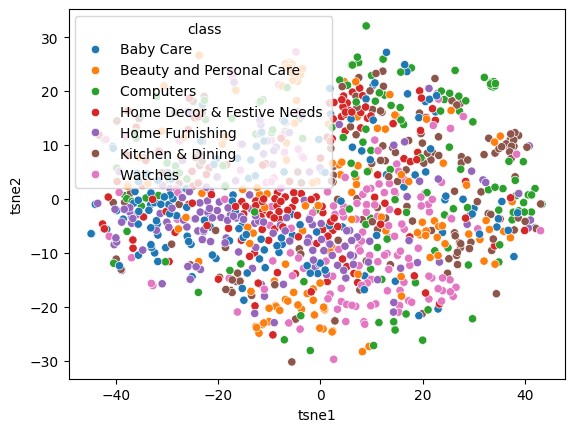

In [37]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='class')
plt.show()

**ANALYSE DE SIMILARITE ENTRE LES CATEGORIES ET LES CLUSTERS D'IMAGE**

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [39]:
cls = KMeans(n_clusters=len(list_labels), random_state=42)
cls.fit(vbow_pca)

df_tsne["cluster_pca"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [40]:
cls = KMeans(n_clusters=len(list_labels), random_state=42)
cls.fit(df_tsne[['tsne1', 'tsne2']])

df_tsne["cluster_tsne"] = cls.labels_
print(df_tsne.shape)

(1050, 5)


In [41]:
print("ARI PCA : ", adjusted_rand_score(df_tsne["class"], df_tsne["cluster_pca"]))

ARI :  0.03625782646484343


In [42]:
print("ARI TSNE : ", adjusted_rand_score(df_tsne["class"], df_tsne["cluster_tsne"]))

ARI :  0.043399009274608574


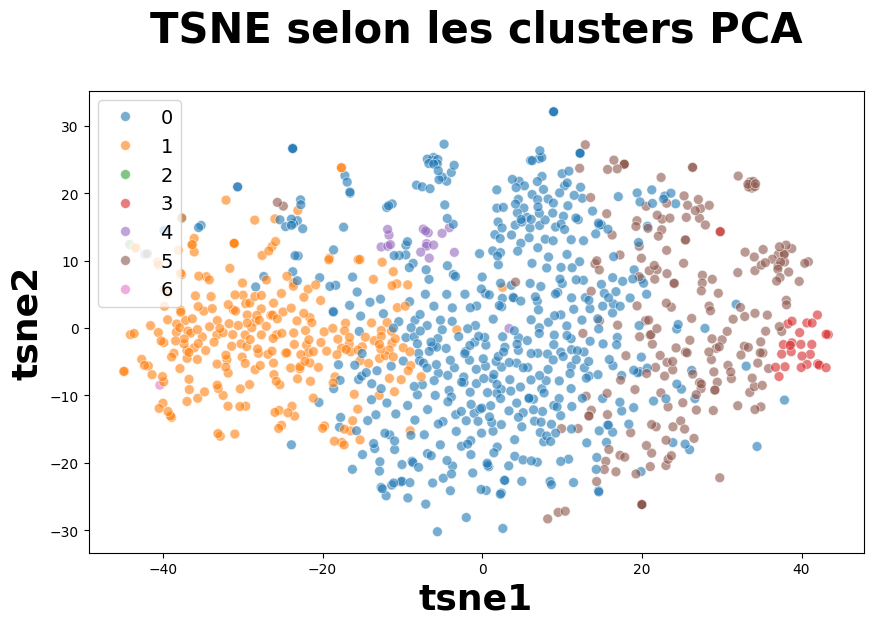

In [43]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_tsne, x='tsne1', y='tsne2', hue='cluster_pca',
    palette=sns.color_palette('tab10', n_colors=len(list_labels)), s=50, alpha=0.6,
    legend="brief")

plt.title('TSNE selon les clusters PCA', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

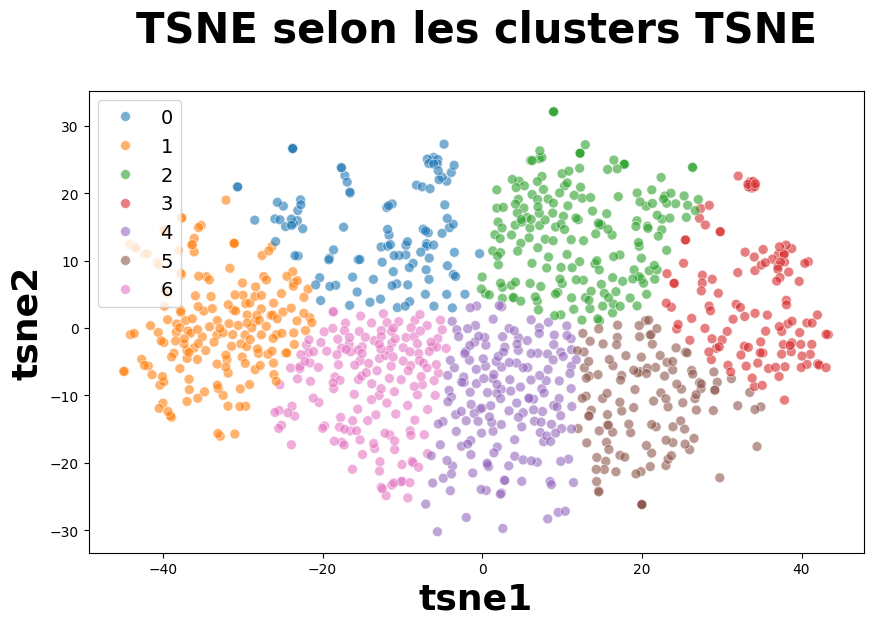

In [44]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_tsne, x='tsne1', y='tsne2', hue='cluster_tsne',
    palette=sns.color_palette('tab10', n_colors=len(list_labels)), s=50, alpha=0.6,
    legend="brief")

plt.title('TSNE selon les clusters TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Pour information, l'ancien score obtenu était de 0.0021.<br>
Nous avons de biens meilleurs résultats avec la phase de preprocessing des images:
0.03 et 0.04